## Пример работы с моделью SARIMAX

In [1]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.3)

### 1. Работа с данными
Загружаем встроенный в `statsmodels` датасет `CO2 в атмосфере из образцов воздуха в обсерватории Мауна-Лоа, Гавайи, США`, с марта 1958 года по декабрь 2001 года. 

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data

Начало ряда

In [3]:
y.head(10)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


Хвост ряда

In [4]:
y.tail()

,co2
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


Конкретный отрезок временного ряда

In [5]:
y.ix['1991-11-01':'1991-12-31']

,co2
1991-11-02,353.4
1991-11-09,353.7
1991-11-16,353.5
1991-11-23,353.8
1991-11-30,354.3
1991-12-07,354.5
1991-12-14,354.9
1991-12-21,355.2
1991-12-28,355.5


Еженедельные данные обрабатывать сложно, так как это более короткий промежуток времени, поэтому давайте вместо этого использовать месячные средние. Обработку сделаем с помощью функции `resample`. Пропуски в данных уберем при помощи функции `fillna` по предыдущим значениям (метод `ffill`).

In [6]:
y = y['co2'].resample('MS').mean()
y = y.fillna(method='ffill')
print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    317.433333
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


Изобразим ряд на графике

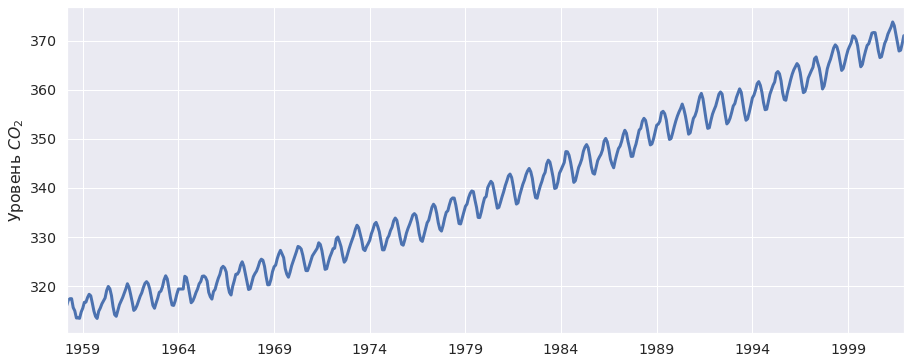

In [7]:
y.plot(figsize=(15, 6), lw=3)
plt.ylabel('Уровень $CO_2$')
plt.show()

### 2. Анализ ряда

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">`statsmodels.graphics.tsaplots.plot_acf`</a>`(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, **kwargs)`

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html">`statsmodels.graphics.tsaplots.plot_pacf`</a>`(x, ax=None, lags=None, alpha=0.05, method='ywm', use_vlines=True, title='Partial Autocorrelation', zero=True, **kwargs)`

* `x` --- временной ряд;
* `lags` --- набор лагов в виде списка или число -- количество лагов (используется `np.arange(lags)`);
* `ax` --- фигура `matplotlib`;
* `alpha` --- уровень доверия для доверительных интервалов.

На графиках по горизонтальной оси изображены лаги. Синими точками отмечены значения функций, для наглядности рисуется также отрезок, соединяющий их с горизонтальной осью. Закрашенная область соответствует области незначимой корреляции. Все значения, лежащие вне закрашенной области признаются значимо отличными от нуля.

Не забываем также, что в нуле значение всегда равно 1 -- корреляция случайной величины с самой собой.

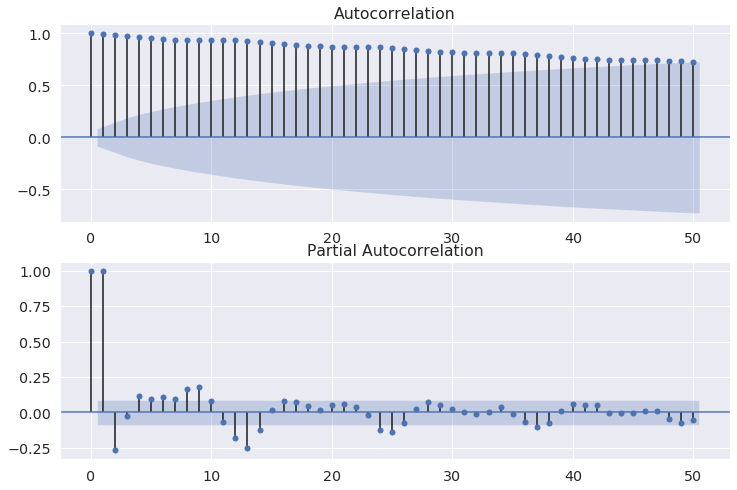

In [8]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=50, ax=ax2)
plt.show()

Ничего хорошего не выходит.
В данных явно есть линейный тренд, что видно по большим значеням автокорреляции. Иначе говоря, чем больше CO2 было в 1980 году, тем больше их будет в 1990. И наоборот.

Продифференцируем ряд и изобразим график полученного ряда.

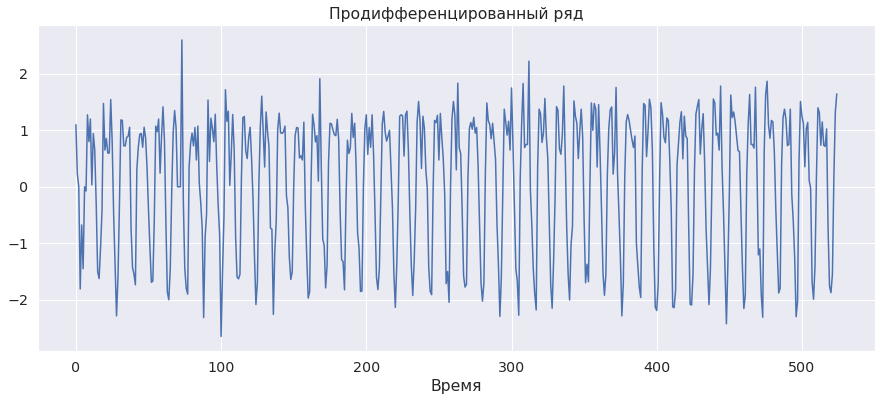

In [9]:
ya = np.array(y)
yt = ya[1:] - ya[:-1]  # дифференцирование

plt.figure(figsize=(15, 6))
plt.plot(yt)
plt.xlabel('Время')
plt.title('Продифференцированный ряд')
plt.show()

Отлично, тренд сняли.

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) для продифференцированного ряда.

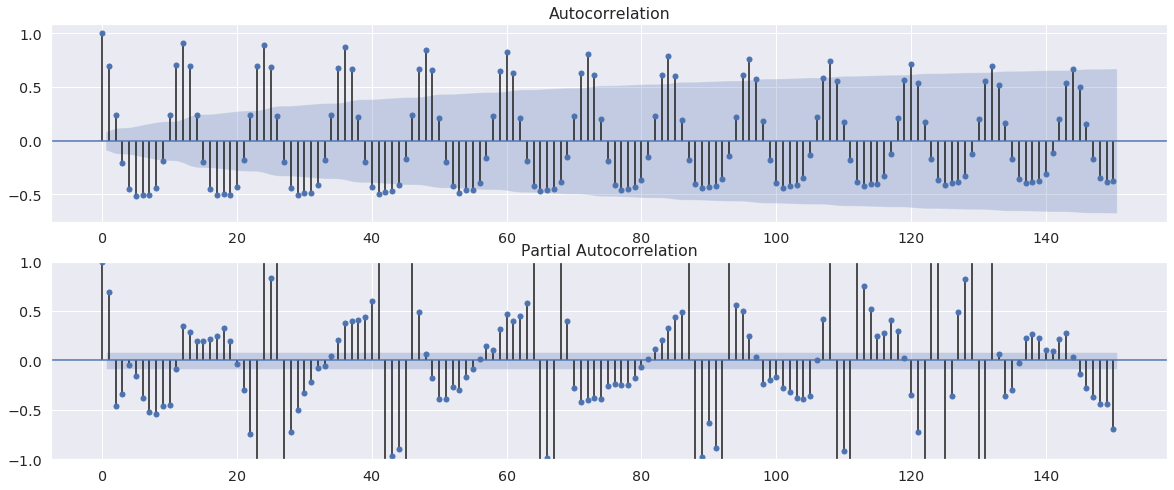

In [10]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(yt, lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(yt, lags=150, ax=ax2)
plt.ylim((-1, 1))
plt.show()

**Замечание. График частичной автокорреляционной функции не должен себя так вести. Это бага в новых версиях `statsmodels`.**

Как график продифференцированного ряда, так и его автокорреляционная функция намекают на сезонность. По графику автокорреляций, например, мы видим положительные пики при значениях лага, кратных 12. Максимальное значение автокорреляции имеет 12-й лаг. Это означает, что чем больше значение ряда было 12 месяцем назад, тем больше оно должно быть сейчас. Наоборот, чем больше значение ряда было 6 месяцев назад, тем меньше оно должно быть сейчас.

Ряд с сезонностью не является стационарным, т.к. распределение ряда меняется в зависимости от сезона. 

Применим дополнительно к нашему ряду еще сезонное дифференцирование.
Период сезонности известен заранее --- 12 месяцев.

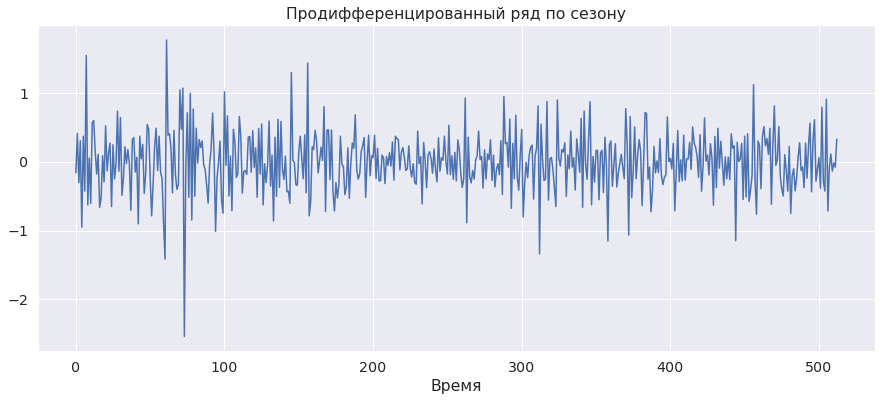

In [11]:
yts = yt[12:] - yt[:-12]

plt.figure(figsize=(15, 6))
plt.plot(yts)
plt.xlabel('Время')
plt.title('Продифференцированный ряд по сезону')
plt.show()

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) после первого дифференцирования и последующего сезонного дифференцирования.

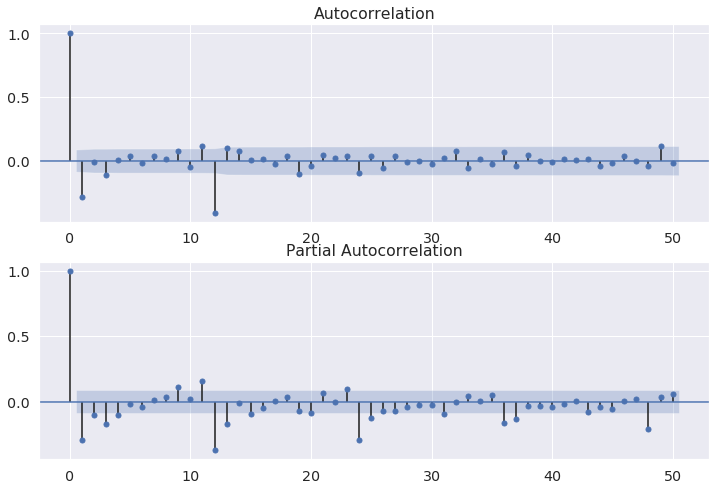

In [12]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(yts, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(yts, lags=50, ax=ax2)
plt.show()

По графикам видно несколько значимых лагов в начале, а так же значимые лаги через периоды сезонности. 

Разберем график автокорреляций. По графику видим, что значимыми являются лаги 1 и 3. Это означает, что в формуле для $y_t$ скорее всего с ненулевыми коэффициентами присутствуют значения $y_{t-1}$ и $y_{t-3}$. Поэтому в качестве начального значения для $p$ можно взять $p=3$. 

Отдельно посмотрим на 12-й лаг, который соответствует периоду сезонности, пояснив, почему не стоит обращать на него внимание при выборе $p$. Мы строили коррелограмму для ряда разностей значений в моменты времени $t$ и $t-12$. Такая разность могла "снять" не всю сезонность. В модели SARIMA значение в момент времени $t-12$ учитывается с некоторым коэффициентом, который мы включим в модель с помощью сезонной компоненты. Значения 12, 24 и т.д. лагов могут помочь при выборе начального значения для $P$. Также для выбора этого значения стоит смотреть на коррелограмму ряда до сезонной дифференцирования.

Разберем график частичных автокорреляций. По определению частичная автокорреляция это корреляция значения ряда после снятия с него линейной зависимости от предыдущих значений ряда. В идеале такое снятие линейной зависимости означает, что в формуле для $y_t$ не должно остаться предыдущих значений ряда. Это означает, что в ней остается только линейная комбинация шума. Как раз таки корреляцию с ним мы и рассмотрим.

На графике частичных автокорреляций мы видим, что имеются значимые 1-4 лаги. Поэтому в качестве начальных значений $q$ можно взять 4 или же 3 (т.к. 4-ая близка к незначимой). По сезонным лагам можно подобрать начальное значение для $Q$.

### 3. Выбор модели

Сделаем полный перебор по сетке вокруг начальных значений параметров. Зададим сетку:

In [13]:
p = range(4)
q = range(1, 5)
d = [1]
P = range(3, 8)
D = [1]
Q = range(1, 6)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(P, D, Q))]

Класс, реализующий модель SARIMAX$(p, d, q) \times (P, D, Q)_s$

`class` <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">`statsmodels.tsa.statespace.sarimax.SARIMAX`</a>`(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, **kwargs)`

Параметры:

* `endog` --- временной ряд;
* `exog` --- экзогенные факторы (регрессоры);
* `order` = гиперпараметы $(p, d, q)$ модели ARIMA;
* `seasonal_order` = сезонные гиперпараметры $(P, D, Q, s)$
* `trend` --- тренд по времени. Например, если `trend=[1,1,0,1]`, то модель содержит $a + bt + ct^3$. По умолчанию тренд не используется;
* `enforce_stationarity` -- требовать ли стационарность AR компоненты. Если нет, то AR-составляющая модели может задавать нестационарный ряд. Если да, то модель может не подобраться;
* `enforce_invertibility ` -- требовать ли обратимость MA компоненты.

Атрибуты построенной модели:

* `polynomial_ar` --- коэффициенты AR-составляющей;
* `polynomial_ma` --- коэффициенты MA-составляющей;
* `polynomial_seasonal_ar` --- коэффициенты сезонной AR-составляющей;
* `polynomial_seasonal_ma` --- коэффициенты сезонной MA-составляющей;
* `polynomial_trend` --- коэффициенты тренда по времени;
* и другие.

In [14]:
best_aic = np.inf
best_params = None

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(
                y, order=param, seasonal_order=param_seasonal, 
                # не будем требовать жесткие теоретические условия
                enforce_stationarity=False, enforce_invertibility=False
            )
            model = model.fit()
            print('ARIMA{}x{} – AIC: {:.2f}'.format(param, param_seasonal, 
                                                    model.aic))
            
            # Если нашли более подходящую модель
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = param, param_seasonal
                
        except:
            # Если модель построить не получится, то она выдаст исключение
            continue

ARIMA(0, 1, 1)x(3, 1, 1, 12) – AIC: 274.75
ARIMA(0, 1, 1)x(3, 1, 2, 12) – AIC: 280.21
ARIMA(0, 1, 1)x(3, 1, 3, 12) – AIC: 255.83
ARIMA(0, 1, 1)x(3, 1, 4, 12) – AIC: 253.08


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(3, 1, 5, 12) – AIC: 208.16
ARIMA(0, 1, 1)x(4, 1, 1, 12) – AIC: 281.29
ARIMA(0, 1, 1)x(4, 1, 2, 12) – AIC: 279.23
ARIMA(0, 1, 1)x(4, 1, 3, 12) – AIC: 241.79
ARIMA(0, 1, 1)x(4, 1, 4, 12) – AIC: 241.98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(4, 1, 5, 12) – AIC: 200.70
ARIMA(0, 1, 1)x(5, 1, 1, 12) – AIC: 271.03
ARIMA(0, 1, 1)x(5, 1, 2, 12) – AIC: 270.28
ARIMA(0, 1, 1)x(5, 1, 3, 12) – AIC: 230.96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(5, 1, 4, 12) – AIC: 233.12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(5, 1, 5, 12) – AIC: 205.00
ARIMA(0, 1, 1)x(6, 1, 1, 12) – AIC: 222.50
ARIMA(0, 1, 1)x(6, 1, 2, 12) – AIC: 220.72
ARIMA(0, 1, 1)x(6, 1, 3, 12) – AIC: 216.79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(6, 1, 4, 12) – AIC: 209.03


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(6, 1, 5, 12) – AIC: 200.55
ARIMA(0, 1, 1)x(7, 1, 1, 12) – AIC: 190.57
ARIMA(0, 1, 1)x(7, 1, 2, 12) – AIC: 192.27
ARIMA(0, 1, 1)x(7, 1, 3, 12) – AIC: 183.73
ARIMA(0, 1, 1)x(7, 1, 4, 12) – AIC: 184.59
ARIMA(0, 1, 1)x(7, 1, 5, 12) – AIC: 185.66


ARIMA(0, 1, 2)x(3, 1, 1, 12) – AIC: 272.35
ARIMA(0, 1, 2)x(3, 1, 2, 12) – AIC: 277.74
ARIMA(0, 1, 2)x(3, 1, 3, 12) – AIC: 254.07
ARIMA(0, 1, 2)x(3, 1, 4, 12) – AIC: 246.72
ARIMA(0, 1, 2)x(3, 1, 5, 12) – AIC: 199.99
ARIMA(0, 1, 2)x(4, 1, 1, 12) – AIC: 279.49
ARIMA(0, 1, 2)x(4, 1, 2, 12) – AIC: 278.12
ARIMA(0, 1, 2)x(4, 1, 3, 12) – AIC: 241.06
ARIMA(0, 1, 2)x(4, 1, 4, 12) – AIC: 241.27


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(4, 1, 5, 12) – AIC: 201.87
ARIMA(0, 1, 2)x(5, 1, 1, 12) – AIC: 271.23
ARIMA(0, 1, 2)x(5, 1, 2, 12) – AIC: 270.62


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(5, 1, 3, 12) – AIC: 231.06


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(5, 1, 4, 12) – AIC: 235.37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(5, 1, 5, 12) – AIC: 200.60
ARIMA(0, 1, 2)x(6, 1, 1, 12) – AIC: 224.01
ARIMA(0, 1, 2)x(6, 1, 2, 12) – AIC: 222.32
ARIMA(0, 1, 2)x(6, 1, 3, 12) – AIC: 218.67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(6, 1, 4, 12) – AIC: 210.76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(6, 1, 5, 12) – AIC: 202.50
ARIMA(0, 1, 2)x(7, 1, 1, 12) – AIC: 191.55
ARIMA(0, 1, 2)x(7, 1, 2, 12) – AIC: 193.23
ARIMA(0, 1, 2)x(7, 1, 3, 12) – AIC: 184.97
ARIMA(0, 1, 2)x(7, 1, 4, 12) – AIC: 185.98
ARIMA(0, 1, 2)x(7, 1, 5, 12) – AIC: 187.05


ARIMA(0, 1, 3)x(3, 1, 1, 12) – AIC: 272.68
ARIMA(0, 1, 3)x(3, 1, 2, 12) – AIC: 278.11
ARIMA(0, 1, 3)x(3, 1, 3, 12) – AIC: 254.50
ARIMA(0, 1, 3)x(3, 1, 4, 12) – AIC: 245.89
ARIMA(0, 1, 3)x(3, 1, 5, 12) – AIC: 202.28
ARIMA(0, 1, 3)x(4, 1, 1, 12) – AIC: 279.74
ARIMA(0, 1, 3)x(4, 1, 2, 12) – AIC: 278.74
ARIMA(0, 1, 3)x(4, 1, 3, 12) – AIC: 242.10
ARIMA(0, 1, 3)x(4, 1, 4, 12) – AIC: 240.26


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(4, 1, 5, 12) – AIC: 199.63
ARIMA(0, 1, 3)x(5, 1, 1, 12) – AIC: 272.42
ARIMA(0, 1, 3)x(5, 1, 2, 12) – AIC: 271.91
ARIMA(0, 1, 3)x(5, 1, 3, 12) – AIC: 236.32


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(5, 1, 4, 12) – AIC: 236.66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(5, 1, 5, 12) – AIC: 200.77
ARIMA(0, 1, 3)x(6, 1, 1, 12) – AIC: 226.00
ARIMA(0, 1, 3)x(6, 1, 2, 12) – AIC: 224.32
ARIMA(0, 1, 3)x(6, 1, 3, 12) – AIC: 220.58
ARIMA(0, 1, 3)x(6, 1, 4, 12) – AIC: 212.75
ARIMA(0, 1, 3)x(6, 1, 5, 12) – AIC: 204.32
ARIMA(0, 1, 3)x(7, 1, 1, 12) – AIC: 193.41
ARIMA(0, 1, 3)x(7, 1, 2, 12) – AIC: 195.05
ARIMA(0, 1, 3)x(7, 1, 3, 12) – AIC: 186.92
ARIMA(0, 1, 3)x(7, 1, 4, 12) – AIC: 187.94
ARIMA(0, 1, 3)x(7, 1, 5, 12) – AIC: 189.02


ARIMA(0, 1, 4)x(3, 1, 1, 12) – AIC: 274.67
ARIMA(0, 1, 4)x(3, 1, 2, 12) – AIC: 280.11
ARIMA(0, 1, 4)x(3, 1, 3, 12) – AIC: 256.67
ARIMA(0, 1, 4)x(3, 1, 4, 12) – AIC: 246.95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 4)x(3, 1, 5, 12) – AIC: 205.66
ARIMA(0, 1, 4)x(4, 1, 1, 12) – AIC: 281.73
ARIMA(0, 1, 4)x(4, 1, 2, 12) – AIC: 280.57
ARIMA(0, 1, 4)x(4, 1, 3, 12) – AIC: 243.90
ARIMA(0, 1, 4)x(4, 1, 4, 12) – AIC: 242.07


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 4)x(4, 1, 5, 12) – AIC: 201.84
ARIMA(0, 1, 4)x(5, 1, 1, 12) – AIC: 274.40
ARIMA(0, 1, 4)x(5, 1, 2, 12) – AIC: 273.86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 4)x(5, 1, 3, 12) – AIC: 234.21


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 4)x(5, 1, 4, 12) – AIC: 239.36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 4)x(5, 1, 5, 12) – AIC: 205.32
ARIMA(0, 1, 4)x(6, 1, 1, 12) – AIC: 228.00
ARIMA(0, 1, 4)x(6, 1, 2, 12) – AIC: 226.32
ARIMA(0, 1, 4)x(6, 1, 3, 12) – AIC: 222.20
ARIMA(0, 1, 4)x(6, 1, 4, 12) – AIC: 214.71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 4)x(6, 1, 5, 12) – AIC: 206.30
ARIMA(0, 1, 4)x(7, 1, 1, 12) – AIC: 195.13
ARIMA(0, 1, 4)x(7, 1, 2, 12) – AIC: 196.78
ARIMA(0, 1, 4)x(7, 1, 3, 12) – AIC: 188.69
ARIMA(0, 1, 4)x(7, 1, 4, 12) – AIC: 189.74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 4)x(7, 1, 5, 12) – AIC: 192.00


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 1, 12) – AIC: 271.56
ARIMA(1, 1, 1)x(3, 1, 2, 12) – AIC: 276.25
ARIMA(1, 1, 1)x(3, 1, 3, 12) – AIC: 253.30


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 4, 12) – AIC: 250.86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 5, 12) – AIC: 205.71
ARIMA(1, 1, 1)x(4, 1, 1, 12) – AIC: 277.10
ARIMA(1, 1, 1)x(4, 1, 2, 12) – AIC: 275.80
ARIMA(1, 1, 1)x(4, 1, 3, 12) – AIC: 240.30


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(4, 1, 4, 12) – AIC: 240.64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(4, 1, 5, 12) – AIC: 207.27
ARIMA(1, 1, 1)x(5, 1, 1, 12) – AIC: 259.30
ARIMA(1, 1, 1)x(5, 1, 2, 12) – AIC: 259.94
ARIMA(1, 1, 1)x(5, 1, 3, 12) – AIC: 224.81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(5, 1, 4, 12) – AIC: 215.97


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(5, 1, 5, 12) – AIC: 204.55
ARIMA(1, 1, 1)x(6, 1, 1, 12) – AIC: 224.36
ARIMA(1, 1, 1)x(6, 1, 2, 12) – AIC: 222.58


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(6, 1, 3, 12) – AIC: 212.80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(6, 1, 4, 12) – AIC: 211.03


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(6, 1, 5, 12) – AIC: 200.31
ARIMA(1, 1, 1)x(7, 1, 1, 12) – AIC: 191.40
ARIMA(1, 1, 1)x(7, 1, 2, 12) – AIC: 192.80
ARIMA(1, 1, 1)x(7, 1, 3, 12) – AIC: 185.13


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(7, 1, 4, 12) – AIC: 186.26


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(7, 1, 5, 12) – AIC: 187.27


ARIMA(1, 1, 2)x(3, 1, 1, 12) – AIC: 273.07
ARIMA(1, 1, 2)x(3, 1, 2, 12) – AIC: 278.14
ARIMA(1, 1, 2)x(3, 1, 3, 12) – AIC: 255.25


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 4, 12) – AIC: 248.42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 5, 12) – AIC: 201.82
ARIMA(1, 1, 2)x(4, 1, 1, 12) – AIC: 278.93
ARIMA(1, 1, 2)x(4, 1, 2, 12) – AIC: 277.56
ARIMA(1, 1, 2)x(4, 1, 3, 12) – AIC: 242.01


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(4, 1, 4, 12) – AIC: 242.19


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(4, 1, 5, 12) – AIC: 201.84
ARIMA(1, 1, 2)x(5, 1, 1, 12) – AIC: 261.15
ARIMA(1, 1, 2)x(5, 1, 2, 12) – AIC: 261.82
ARIMA(1, 1, 2)x(5, 1, 3, 12) – AIC: 217.49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(5, 1, 4, 12) – AIC: 221.14
ARIMA(1, 1, 2)x(5, 1, 5, 12) – AIC: 206.74
ARIMA(1, 1, 2)x(6, 1, 1, 12) – AIC: 226.35
ARIMA(1, 1, 2)x(6, 1, 2, 12) – AIC: 224.59


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(6, 1, 3, 12) – AIC: 214.67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(6, 1, 4, 12) – AIC: 213.02


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(6, 1, 5, 12) – AIC: 202.31
ARIMA(1, 1, 2)x(7, 1, 1, 12) – AIC: 193.20


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(7, 1, 2, 12) – AIC: 194.53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(7, 1, 3, 12) – AIC: 186.93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(7, 1, 4, 12) – AIC: 188.05


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(7, 1, 5, 12) – AIC: 189.21


ARIMA(1, 1, 3)x(3, 1, 1, 12) – AIC: 274.72
ARIMA(1, 1, 3)x(3, 1, 2, 12) – AIC: 279.74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 3, 12) – AIC: 256.49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 4, 12) – AIC: 247.71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 5, 12) – AIC: 202.86
ARIMA(1, 1, 3)x(4, 1, 1, 12) – AIC: 280.46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(4, 1, 2, 12) – AIC: 279.12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(4, 1, 3, 12) – AIC: 243.95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(4, 1, 4, 12) – AIC: 242.23


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(4, 1, 5, 12) – AIC: 201.71
ARIMA(1, 1, 3)x(5, 1, 1, 12) – AIC: 262.89
ARIMA(1, 1, 3)x(5, 1, 2, 12) – AIC: 263.55


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(5, 1, 3, 12) – AIC: 219.57


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(5, 1, 4, 12) – AIC: 223.79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(5, 1, 5, 12) – AIC: 202.79
ARIMA(1, 1, 3)x(6, 1, 1, 12) – AIC: 228.36
ARIMA(1, 1, 3)x(6, 1, 2, 12) – AIC: 226.58


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(6, 1, 3, 12) – AIC: 216.55
ARIMA(1, 1, 3)x(6, 1, 4, 12) – AIC: 215.03


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(6, 1, 5, 12) – AIC: 204.00
ARIMA(1, 1, 3)x(7, 1, 1, 12) – AIC: 195.20


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(7, 1, 2, 12) – AIC: 196.53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(7, 1, 3, 12) – AIC: 189.00


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(7, 1, 4, 12) – AIC: 190.28


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(7, 1, 5, 12) – AIC: 191.28


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(3, 1, 1, 12) – AIC: 276.87
ARIMA(1, 1, 4)x(3, 1, 2, 12) – AIC: 281.70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(3, 1, 3, 12) – AIC: 258.44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(3, 1, 4, 12) – AIC: 250.14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(3, 1, 5, 12) – AIC: 207.41
ARIMA(1, 1, 4)x(4, 1, 1, 12) – AIC: 282.39
ARIMA(1, 1, 4)x(4, 1, 2, 12) – AIC: 281.14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(4, 1, 3, 12) – AIC: 245.93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(4, 1, 4, 12) – AIC: 244.07


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(4, 1, 5, 12) – AIC: 209.25
ARIMA(1, 1, 4)x(5, 1, 1, 12) – AIC: 264.85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(5, 1, 2, 12) – AIC: 265.52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(5, 1, 3, 12) – AIC: 221.65
ARIMA(1, 1, 4)x(5, 1, 4, 12) – AIC: 225.45


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(5, 1, 5, 12) – AIC: 204.60


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(6, 1, 1, 12) – AIC: 230.34


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(6, 1, 2, 12) – AIC: 228.58


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(6, 1, 3, 12) – AIC: 218.14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(6, 1, 4, 12) – AIC: 216.93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(6, 1, 5, 12) – AIC: 205.71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(7, 1, 1, 12) – AIC: 197.04


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(7, 1, 2, 12) – AIC: 198.41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(7, 1, 3, 12) – AIC: 190.73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(7, 1, 4, 12) – AIC: 191.81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(7, 1, 5, 12) – AIC: 192.86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 1, 12) – AIC: 271.73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 2, 12) – AIC: 272.40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 3, 12) – AIC: 267.96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 4, 12) – AIC: 249.17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 5, 12) – AIC: 211.00
ARIMA(2, 1, 1)x(4, 1, 1, 12) – AIC: 276.48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(4, 1, 2, 12) – AIC: 276.51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(4, 1, 3, 12) – AIC: 241.51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(4, 1, 4, 12) – AIC: 242.31


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(4, 1, 5, 12) – AIC: 211.75
ARIMA(2, 1, 1)x(5, 1, 1, 12) – AIC: 246.33


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(5, 1, 2, 12) – AIC: 239.27


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(5, 1, 3, 12) – AIC: 208.37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(5, 1, 4, 12) – AIC: 213.63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(5, 1, 5, 12) – AIC: 204.46
ARIMA(2, 1, 1)x(6, 1, 1, 12) – AIC: 217.23
ARIMA(2, 1, 1)x(6, 1, 2, 12) – AIC: 218.89


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(6, 1, 3, 12) – AIC: 200.77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(6, 1, 4, 12) – AIC: 202.82


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(6, 1, 5, 12) – AIC: 206.66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(7, 1, 1, 12) – AIC: 193.12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(7, 1, 2, 12) – AIC: 194.95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(7, 1, 3, 12) – AIC: 185.91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(7, 1, 4, 12) – AIC: 187.90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(7, 1, 5, 12) – AIC: 189.30


ARIMA(2, 1, 2)x(3, 1, 1, 12) – AIC: 273.38
ARIMA(2, 1, 2)x(3, 1, 2, 12) – AIC: 277.28


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 3, 12) – AIC: 257.20


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 4, 12) – AIC: 249.90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 5, 12) – AIC: 203.63
ARIMA(2, 1, 2)x(4, 1, 1, 12) – AIC: 278.31
ARIMA(2, 1, 2)x(4, 1, 2, 12) – AIC: 278.35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(4, 1, 3, 12) – AIC: 243.51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(4, 1, 4, 12) – AIC: 244.23


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(4, 1, 5, 12) – AIC: 204.03
ARIMA(2, 1, 2)x(5, 1, 1, 12) – AIC: 247.06
ARIMA(2, 1, 2)x(5, 1, 2, 12) – AIC: 241.17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(5, 1, 3, 12) – AIC: 212.14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(5, 1, 4, 12) – AIC: 211.51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(5, 1, 5, 12) – AIC: 209.58


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(6, 1, 1, 12) – AIC: 218.59


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(6, 1, 2, 12) – AIC: 220.97


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(6, 1, 3, 12) – AIC: 202.91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(6, 1, 4, 12) – AIC: 204.59


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(6, 1, 5, 12) – AIC: 206.26


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(7, 1, 1, 12) – AIC: 195.08


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(7, 1, 2, 12) – AIC: 197.01
ARIMA(2, 1, 2)x(7, 1, 3, 12) – AIC: 187.96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(7, 1, 4, 12) – AIC: 189.96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(7, 1, 5, 12) – AIC: 191.48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 1, 12) – AIC: 274.92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 2, 12) – AIC: 278.91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 3, 12) – AIC: 258.49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 4, 12) – AIC: 248.88


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 5, 12) – AIC: 204.73
ARIMA(2, 1, 3)x(4, 1, 1, 12) – AIC: 280.00


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(4, 1, 2, 12) – AIC: 280.07


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(4, 1, 3, 12) – AIC: 245.51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(4, 1, 4, 12) – AIC: 244.09


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(4, 1, 5, 12) – AIC: 203.69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(5, 1, 1, 12) – AIC: 248.49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(5, 1, 2, 12) – AIC: 242.80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(5, 1, 3, 12) – AIC: 214.11


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(5, 1, 4, 12) – AIC: 213.17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(5, 1, 5, 12) – AIC: 204.81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(6, 1, 1, 12) – AIC: 220.63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(6, 1, 2, 12) – AIC: 222.72


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(6, 1, 3, 12) – AIC: 204.66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(6, 1, 4, 12) – AIC: 206.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(6, 1, 5, 12) – AIC: 208.29
ARIMA(2, 1, 3)x(7, 1, 1, 12) – AIC: 197.07


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(7, 1, 2, 12) – AIC: 198.85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(7, 1, 3, 12) – AIC: 189.77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(7, 1, 4, 12) – AIC: 192.13


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(7, 1, 5, 12) – AIC: 193.37


ARIMA(2, 1, 4)x(3, 1, 1, 12) – AIC: 276.90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(3, 1, 2, 12) – AIC: 280.93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(3, 1, 3, 12) – AIC: 260.45


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(3, 1, 4, 12) – AIC: 251.76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(3, 1, 5, 12) – AIC: 209.43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(4, 1, 1, 12) – AIC: 281.92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(4, 1, 2, 12) – AIC: 281.81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(4, 1, 3, 12) – AIC: 247.39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(4, 1, 4, 12) – AIC: 245.98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(4, 1, 5, 12) – AIC: 211.24
ARIMA(2, 1, 4)x(5, 1, 1, 12) – AIC: 248.26


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(5, 1, 2, 12) – AIC: 243.73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(5, 1, 3, 12) – AIC: 214.78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(5, 1, 4, 12) – AIC: 215.88


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(5, 1, 5, 12) – AIC: 206.56


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(6, 1, 1, 12) – AIC: 215.49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(6, 1, 2, 12) – AIC: 224.49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(6, 1, 3, 12) – AIC: 206.19


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(6, 1, 4, 12) – AIC: 207.89


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(6, 1, 5, 12) – AIC: 209.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(7, 1, 1, 12) – AIC: 198.76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(7, 1, 2, 12) – AIC: 200.58


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(7, 1, 3, 12) – AIC: 191.42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(7, 1, 4, 12) – AIC: 193.48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 4)x(7, 1, 5, 12) – AIC: 194.78


ARIMA(3, 1, 1)x(3, 1, 1, 12) – AIC: 273.46
ARIMA(3, 1, 1)x(3, 1, 2, 12) – AIC: 277.22


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 3, 12) – AIC: 257.05


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 4, 12) – AIC: 250.38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 5, 12) – AIC: 209.42
ARIMA(3, 1, 1)x(4, 1, 1, 12) – AIC: 277.96
ARIMA(3, 1, 1)x(4, 1, 2, 12) – AIC: 278.25
ARIMA(3, 1, 1)x(4, 1, 3, 12) – AIC: 243.36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(4, 1, 4, 12) – AIC: 244.13


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(4, 1, 5, 12) – AIC: 209.85
ARIMA(3, 1, 1)x(5, 1, 1, 12) – AIC: 242.36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(5, 1, 2, 12) – AIC: 236.90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(5, 1, 3, 12) – AIC: 209.27


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(5, 1, 4, 12) – AIC: 208.17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(5, 1, 5, 12) – AIC: 202.93
ARIMA(3, 1, 1)x(6, 1, 1, 12) – AIC: 215.87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(6, 1, 2, 12) – AIC: 217.58


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(6, 1, 3, 12) – AIC: 199.52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergen

limit_output extension: Maximum message size of 50000 exceeded with 50011 characters

Оптимальной является модель

In [15]:
print('ARIMA{}x{}'.format(param, param_seasonal))

ARIMA(3, 1, 4)x(7, 1, 5, 12)



### 4. Анализ статистических свойств модели

Обучим эту модель и выведем некоторе статистические свойства

In [16]:
model = sm.tsa.statespace.SARIMAX(
    y, order=(3, 1, 4), seasonal_order=(7, 1, 5, 12),
    enforce_stationarity=False, enforce_invertibility=False
)

model = model.fit()
print(model.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4098      0.796      0.515      0.607      -1.150       1.970
ar.L2         -0.8354      0.116     -7.198      0.000      -1.063      -0.608
ar.L3          0.2978      0.702      0.424      0.671      -1.078       1.674
ma.L1         -0.7382      0.802     -0.920      0.358      -2.311       0.834
ma.L2          0.9378      0.350      2.679      0.007       0.252       1.624
ma.L3         -0.5611      0.731     -0.768      0.443      -1.993       0.871
ma.L4          0.0470      0.260      0.181      0.856      -0.462       0.556
ar.S.L12      -0.4924      0.249     -1.976      0.048      -0.981      -0.004
ar.S.L24      -0.4392      0.186     -2.365      0.018      -0.803      -0.075
ar.S.L36      -0.1851      0.189     -0.979      0.328      -0.556       0.186
ar.S.L48      -0.0456      0.137     -0.333      0.7

*Описание таблицы*:

* В первом столбце выписаны названия коэффициентов. Например, `ar.L2` --- название коэффициента перед второй авторегрессионной компонентой, то есть перед $y_{t-2}$; а `ma.S.L12` --- название коэффициента перед первой сезонной компонентой модели скользящего среднего, то есть перед $\varepsilon_{t-12}$.

* Второй и третий столбцы (`coef` и `std err`) --- оценки коэффициента и стандартного отклонения.

* Четвертый и пятый столбцы отвечают проверке гипотезы о значимости коэффициента ($\mathsf{H}_0\colon$ коэффициент равен 0 $vs. \mathsf{H}_1\colon$ коэффициент не равен 0; см. линейные гипотезы в гауссовской модели). Столбец `z` --- значение статистики критерия, столбец `P>|z|` --- p-value критерия.

* Последние два столбца отвечают за 95%-доверительный интервал. Можно заметить, что доверительный интервал содержит 0 только для незначимых коэффициентов.

--------------------

Полная таблица статистических свойств модели

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                              co2   No. Observations:                  526
Model:             SARIMAX(3, 1, 4)x(7, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                 -76.973
Date:                                          Wed, 01 Apr 2020   AIC                            193.946
Time:                                                  08:20:12   BIC                            275.035
Sample:                                              03-01-1958   HQIC                           225.978
                                                   - 12-01-2001                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4098      0.796      0.515      0.607      -1.150       1.970
ar.L2         -0.8354      0.116     -7.198      0.000      -1.063      -0.608
ar.L3          0.2978      0.702      0.424      0.671      -1.078       1.674
ma.L1         -0.7382      0.802     -0.920      0.358      -2.311       0.834
ma.L2          0.9378      0.350      2.679      0.007       0.252       1.624
ma.L3         -0.5611      0.731     -0.768      0.443      -1.993       0.871
ma.L4          0.0470      0.260      0.181      0.856      -0.462       0.556
ar.S.L12      -0.4924      0.249     -1.976      0.048      -0.981      -0.004
ar.S.L24      -0.4392      0.186     -2.365      0.018      -0.803      -0.075
ar.S.L36      -0.1851      0.189     -0.979      0.328      -0.556       0.186
ar.S.L48      -0.0456      0.137     -0.333      0.739      -0.314       0.223
ar.S.L60      -0.1153      0.062     -1.859      0.063      -0.237       0.006
ar.S.L72      -0.1119      0.054     -2.076      0.038      -0.218      -0.006
ar.S.L84      -0.0015      0.002     -0.662      0.508      -0.006       0.003
ma.S.L12      -0.3179      0.256     -1.240      0.215      -0.821       0.185
ma.S.L24      -0.0037      0.186     -0.020      0.984      -0.368       0.361
ma.S.L36      -0.2445      0.125     -1.954      0.051      -0.490       0.001
ma.S.L48      -0.1594      0.137     -1.160      0.246      -0.429       0.110
ma.S.L60       0.1225      0.121      1.008      0.313      -0.116       0.361
sigma2         0.0827      0.006     14.436      0.000       0.071       0.094
===================================================================================
Ljung-Box (Q):                       27.97   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.92   Prob(JB):                         0.85
Heteroskedasticity (H):               1.09   Skew:                             0.04
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

В последней таблице приведены значения статистик и pvalue для критериев Льюнга-Бокса (автокоррелированность), проверки на гомоскедастичность и критерий Жарка-Бера (нормальность). Кроме того, приведены значения коэффициентов ассиметрии и эксцесса.

--------------------

Метод `plot_diagnostics` позволяет быстро сделать диагностику модели и исследовать любое необычное поведение.

Первый график --- график остатков модели.
На следующем графике (верхний правый) изображена гистограмма для остатков, ядерная оценка плостности и плотность стандартного нормального распределения.
Третий график Q-Q plot служит для визуальной проверки нормальности. 

По графикам видно, что данные согласуются с нормальным распределением.

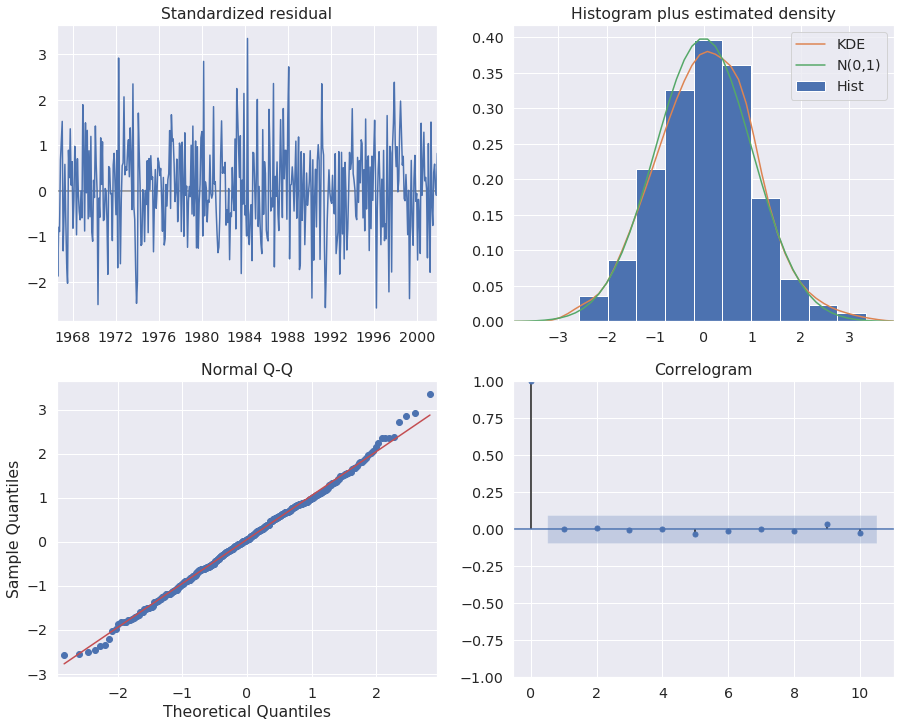

In [18]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

### 5. Прогнозирование

#### 5.1 Прогнозирование на обучении

Начнем с сравнения прогнозируемых значений с реальными значениями временного ряда, чтобы понять насколько точны наши прогнозы.

Метод `get_prediction` у обученной модели позволяет получать прогнозы.
В коде в параметре `start` мы момент начала прогнозирования -- прогнозы начинаются с января 1998 года.

Значение параметра `dynamic = False` гарантирует, что мы создаем прогнозы только на один шаг вперед. Иначе говоря, прогноз в каждой точке вычисляется с использованием полной истории ряда, вплоть до этой точки.

In [19]:
# прогнозы на обучении
pred = model.get_prediction(start=pd.to_datetime('1998-01-01'), 
                            dynamic=False)

Сами прогозы

In [20]:
pred_mean = pred.predicted_mean
pred_mean.head()

1998-01-01    365.037801
1998-02-01    366.046416
1998-03-01    367.095686
1998-04-01    368.531179
1998-05-01    369.074706
Freq: MS, dtype: float64

Предсказательные интервалы

In [21]:
pred_ci = pred.conf_int()
pred_ci.head()

,lower co2,upper co2
1998-01-01,364.474324,365.601279
1998-02-01,365.482938,366.609894
1998-03-01,366.532208,367.659164
1998-04-01,367.967702,369.094657
1998-05-01,368.511228,369.638184


Построим график значений временного ряда CO2, чтобы увидеть наши результаты. 

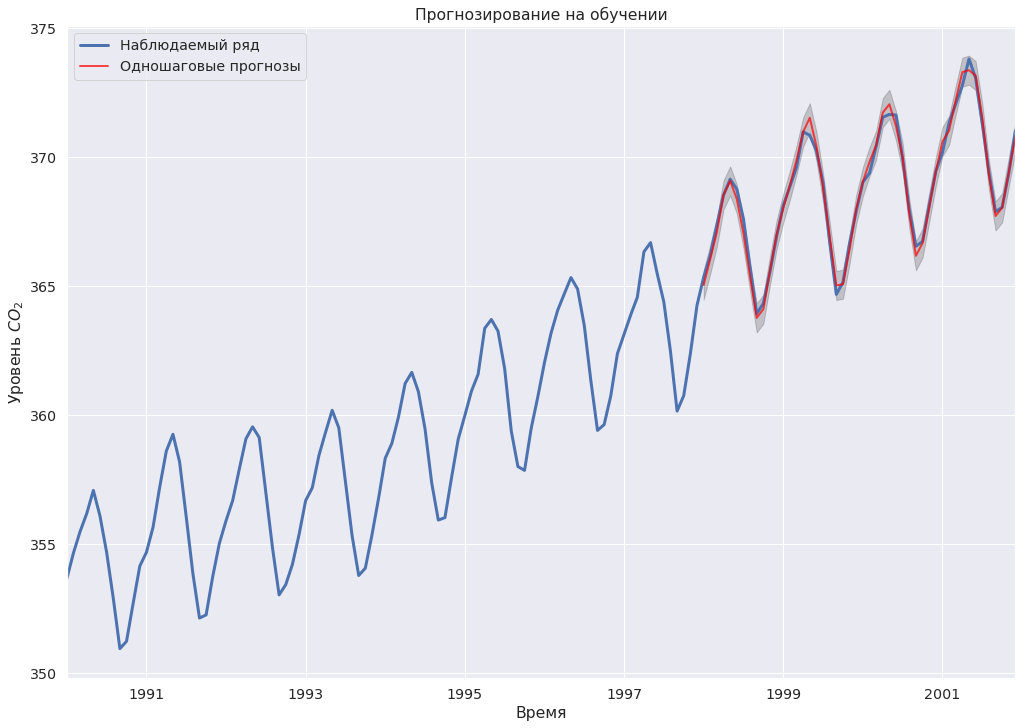

In [22]:
# временной ряд
ax = y['1990':].plot(label='Наблюдаемый ряд', figsize=(17, 12), lw=3)

# прогнозы
pred_mean.plot(ax=ax, label='Одношаговые прогнозы', alpha=.7, 
               lw=2, color='red')
# предсказательный интервал
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                color='k', alpha=.2)

ax.set_xlabel('Время')
ax.set_ylabel('Уровень $CO_2$')
plt.title('Прогнозирование на обучении')
plt.legend()
plt.show()

Посчитаем MSE

In [23]:
y_truth = y['1998-01-01':]
mse = ((pred_mean - y_truth) ** 2).mean()
print('MSE = {:.3f}'.format(mse))

MSE = 0.070


#### 5.2 Динамические прогнозы на обучении

В этом случае мы используем только информацию из временных рядов до определенной точки, а затем прогнозы генерируются с использованием значений из предыдущих прогнозируемых временных точек. Модель при этом обучалась на всем ряде.

В данном коде мы используем именно динамическое прогнозирование и начинаем с января 1998:

In [24]:
pred_dynamic = model.get_prediction(start=pd.to_datetime('1998-01-01'), 
                                    dynamic=True, full_results=True)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()

Построим график. Модель обучалась на всем ряде, но для построения прогнозов используются только значения ряда из незакрашенной области. Для построения следующего прогноза используется предыдущий прогноз. Этим объясняется более широкий доверительный интервал.

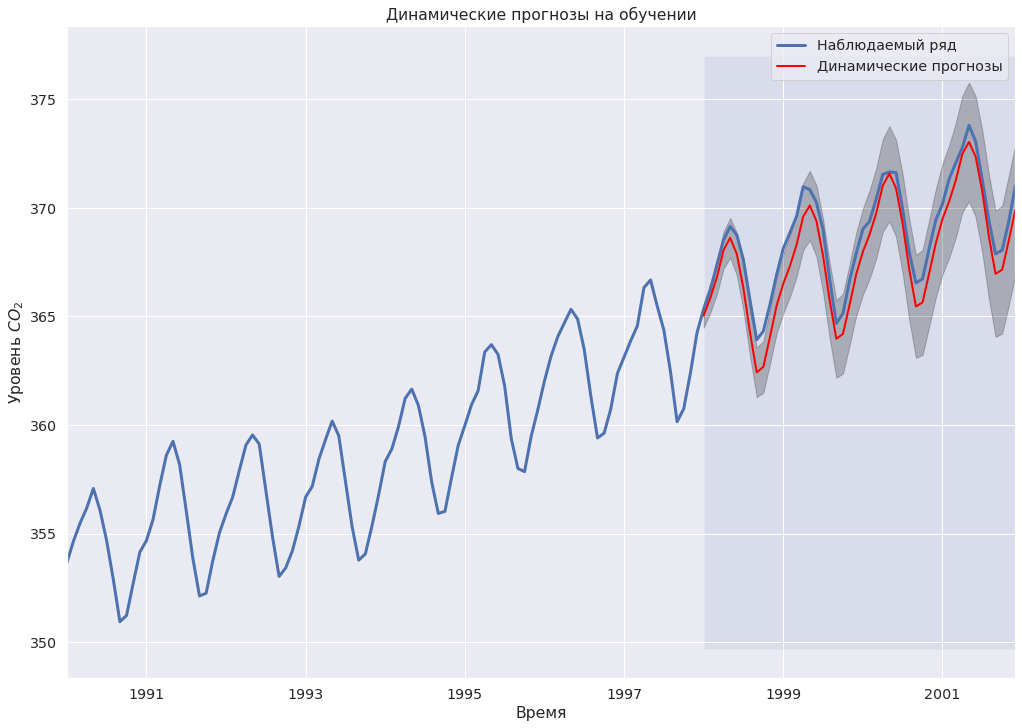

In [25]:
# временной ряд
ax = y['1990':].plot(label='Наблюдаемый ряд', figsize=(17, 12), lw=3)

# прогнозы
pred_mean.plot(label='Динамические прогнозы', ax=ax, lw=2, color='red')
# предсказательный интервал
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], 
                pred_dynamic_ci.iloc[:, 1], 
                color='k', alpha=.25)

# область прогнозирования
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), 
                 y.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Время')
ax.set_ylabel('Уровень $CO_2$')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

Посчитаем MSE

In [26]:
y_truth = y['1998-01-01':]
mse = ((pred_mean - y_truth) ** 2).mean()
print('MSE = {:.3f}'.format(mse))

MSE = 0.982


#### 5.3 Прогноз на далекое будущее (500 месяцев)

Построим прогноз на 500 месяцев вперед и построим график. На том времени мы не могли обучиться -- год 2039 еще не наступил :)

In [27]:
# прогноз на 500 шагов
pred_uc = model.get_forecast(steps=500, dynamic=True)

# сами прогнозы
pred_mean = pred_uc.predicted_mean
# предсказательные интервалы
pred_ci = pred_uc.conf_int()

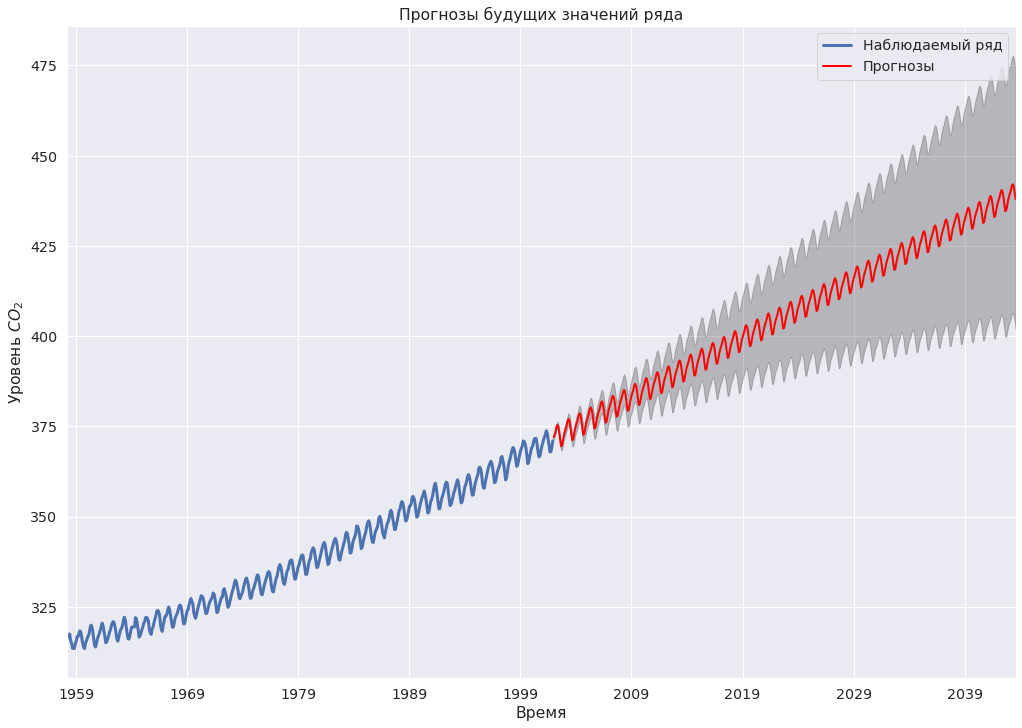

In [28]:
# временной ряд
ax = y.plot(label='Наблюдаемый ряд', figsize=(17, 12), lw=3)
# прогнозы
pred_uc.predicted_mean.plot(ax=ax, label='Прогнозы', lw=2, color='red')
# предсказательный интервал
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                color='k', alpha=.25)

ax.set_xlabel('Время')
ax.set_ylabel('Уровень $CO_2$')
plt.title('Прогнозы будущих значений ряда')
plt.legend()
plt.show()